## Black-box Vector Optimization on Fairness
This notebook contains a vector optimization example on an ML fairness dataset, and compares Naive Elimination and PaVeBa algorithms.

In [ ]:
from copy import deepcopy
from unittest import mock
from typing import Optional

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import torch
from torch import Tensor
import numpy as np
from botorch.test_functions.base import MultiObjectiveTestProblem
import botorch.test_functions.multi_objective as multi_objective
from scipy.integrate import solve_ivp
from scipy.stats.qmc import Sobol

import optuna
from vopy.utils import set_seed
from vopy.order import ConeTheta2DOrder, ConeOrder3D
from vopy.algorithms import PaVeBaGPOnline, VOGP_AD
from vopy.maximization_problem import FixedPointsProblem, ContinuousProblem
from vopy.utils.evaluate import calculate_epsilonF1_score, calculate_hypervolume_discrepancy_for_model

optuna.logging.set_verbosity(optuna.logging.WARNING)

Let's first create an `Order` object to define our preference and visualize it's cone. Our preference correspond to allowing a little trade-off between objectives.

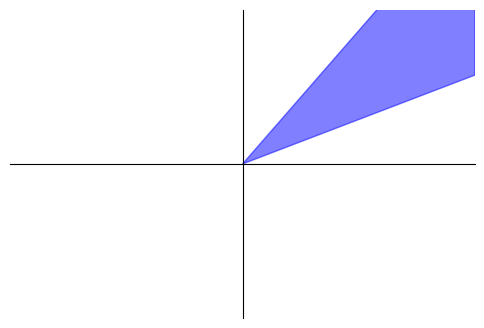

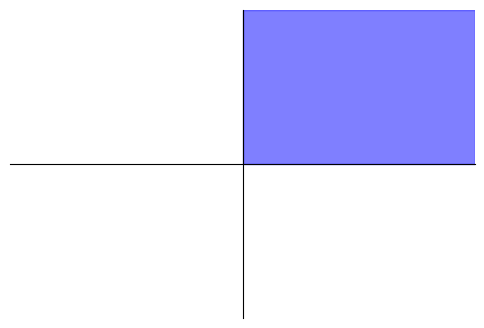

In [2]:
order = ConeTheta2DOrder(cone_degree=30)
order_mo = ConeTheta2DOrder(cone_degree=90)
# order = ConeOrder3D(cone_type="acute")
fig_cone = order.ordering_cone.plot()
fig_cone_mo = order_mo.ordering_cone.plot()

Now, we will create an instance of ML fairness dataset and visualize its Pareto front w.r.t. the order we created. This dataset contains different (200 candidates) hyperparameter selections of ROAD approach on a neural network architecture. The objectives are negative global unfairness measured by disparate impact measure and accuracy of the model. The $x$-axis corresponds to the negative global unfairness and $y$-axis corresponds to the accuracy of the model.

In [3]:
class PK2(MultiObjectiveTestProblem):
    r"""A two objective optimization problem for the Paal-Knorr reaction (PK) between
    2,5-hexanedione and ethanolamine.

    Design space `x = (tau, temperature, equivalents)`:
        - `tau` is the residence time.
        - `temperature` is the temperature.
        - `equivalents` is the equivalents of 3.25 (???).

    Objective `min(log(yield), -log(sty))`:
        - `yield` is the yield of 3.26 %.
        - `sty` is the space-time yield.

    This implementation is adapted from the MATLAB code in
    https://github.com/adamc1994/MultiChem
    """

    dim = 3
    num_objectives = 2
    _bounds = [(0.5, 2), (25, 150), (1, 10)]
    _ref_point = [4.5, -3]

    # Molecular weight
    molecular_weight = 139.20
    # Avogadro
    R = 8.314
    # Absolute zero
    absolute_zero = 273.15
    # volume
    V = 8
    # discretization
    n = 5
    discrete_v = torch.linspace(0, V, n)
    # initial concentration
    C0 = 1

    def __init__(self, noise_std: Optional[float] = None, negate: bool = True) -> None:
        r"""Constructor for PK2.
        Args:
            noise_std: Standard deviation of the observation noise.
            negate: If True, negate the objectives.
        """
        super().__init__(noise_std=noise_std, negate=negate)

    @classmethod
    def solve_ode(cls, X) -> Tensor:
        """
        Args:
            X: A `batch_shape x d`-dim Tensor containing the designs.

        Returns:
            A `batch_shape x M`-dim Tensor containing the objectives.

        """
        # We consider transforming X into `B x d`-dim Tensor and then performing `B`
        # function evaluations. Certain computations are executed in parallel when
        # simple.
        batch_shape = X.shape[:-1]
        B = torch.prod(torch.tensor(batch_shape))
        new_shape = torch.Size([B]) + torch.Size([cls.dim])
        X_reshaped = X.reshape(new_shape)

        # extract design variables
        tau = X_reshaped[:, 0]
        temperature = X_reshaped[:, 1]
        equivalents = X_reshaped[:, 2]

        # concentration
        C_i = torch.zeros(B, cls.n * 4)
        C_i[:, 0] = cls.C0
        C_i[:, cls.n] = cls.C0 * equivalents

        # Integration step
        # Ideally we should integrate in parallel, but scipy.stats.solve_ivp
        # does not have this feature.
        C_final = np.zeros(shape=(B, 4))
        for b in range(B):
            def _integrand_b(t, concentration, temperature):
                flow_rate = cls.V / tau[b]
                conc = concentration[0:cls.n*4].reshape(4, cls.n)
                T = temperature + cls.absolute_zero

                k = (
                    lambda k_ref, E_a: k_ref * np.exp(-E_a / (cls.R * T))
                )
                diff = lambda vec: vec[1:] - vec[0:-1]

                k_a = k(15.40, 12.2e3)
                k_b = k(405.19, 20.0e3)

                A = conc[0, :]
                B = conc[1, :]
                C = conc[2, :]
                D = conc[3, :]

                dAdt = [
                    torch.zeros(1),
                    - flow_rate * diff(A) / diff(cls.discrete_v)
                    - k_a * A[1:] * B[1:]
                ]
                dAdt = torch.cat(dAdt)

                dBdt = [
                    torch.zeros(1),
                    - flow_rate * diff(B) / diff(cls.discrete_v)
                    - k_a * A[1:] * B[1:]
                ]
                dBdt = torch.cat(dBdt)

                dCdt = [
                    torch.zeros(1),
                    - flow_rate * diff(C) / diff(cls.discrete_v)
                    + k_a * A[1:] * B[1:] - k_b * C[1:]
                ]
                dCdt = torch.cat(dCdt)

                dDdt = [
                    torch.zeros(1),
                    - flow_rate * diff(D) / diff(cls.discrete_v)
                    + k_b * C[1:]
                ]
                dDdt = torch.cat(dDdt)

                return torch.cat([dAdt, dBdt, dCdt, dDdt])

            res_b = solve_ivp(
                _integrand_b, [0, 4*tau[b]], C_i[b], args=(temperature[b],)
            )

            C_final[b, :] = torch.tensor(
                [res_b.y[(i+1)*cls.n - 1, -1] for i in range(4)],
                dtype=torch.double
            )

        # Convert numpy array to tensor
        C_final = torch.tensor(C_final, dtype=torch.double)
        sty = 60 * C_final[:, 3] * cls.molecular_weight / tau

        # product = C_final[:, 3] * 100
        # rme = (139.20 * product) / (
        #         114.14 + (61.08 * equivalents)
        # )

        intermediate_yield = C_final[:, 2] * 100 / cls.C0

        obj_values = torch.column_stack(
            [torch.log(intermediate_yield), -torch.log(sty)]
        )

        return obj_values.reshape(batch_shape + torch.Size([cls.num_objectives]))

    def evaluate_true(self, X: Tensor) -> Tensor:
        return self.solve_ode(X)


In [11]:
set_seed(0)

design_count = 300
epsilon = 0.01
delta = 0.05
noise_var = 0.0001
noise_std = noise_var ** 0.5

problem = PK2(noise_std=noise_std, negate=True)
input_bounds = problem._bounds

class PK2_VOPy(ContinuousProblem):
    bounds = np.array(input_bounds)
    in_dim = len(bounds)
    out_dim = 2
    domain_discretization_each_dim = 33
    depth_max = 3

    def __init__(self, noise_var: float) -> None:
        super().__init__(noise_var)

    def evaluate_true(self, x: np.ndarray) -> np.ndarray:
        return problem(torch.tensor(x)).numpy(force=True)

#### Algorithms
We'll now run both algorithms (Naive Elimination and PaVeBa) and print out their results.

In [12]:
set_seed(0)

vopy_problem = PK2_VOPy(noise_var=noise_var)
vopy_alg = VOGP_AD(
    epsilon=epsilon,
    delta=delta,
    problem=vopy_problem,
    order=order,
    noise_var=noise_var,
    conf_contraction=256
)

while True:
    is_done = vopy_alg.run_one_step()

    if is_done:
        break

Round 0:There are 8 designs left in set S and 0 designs in set P.
Round 1:There are 15 designs left in set S and 0 designs in set P.
Round 2:There are 15 designs left in set S and 0 designs in set P.
Round 3:There are 22 designs left in set S and 0 designs in set P.
Round 4:There are 22 designs left in set S and 0 designs in set P.
Round 5:There are 29 designs left in set S and 0 designs in set P.
Round 6:There are 29 designs left in set S and 0 designs in set P.
Round 7:There are 36 designs left in set S and 0 designs in set P.
Round 8:There are 36 designs left in set S and 0 designs in set P.
Round 9:There are 36 designs left in set S and 0 designs in set P.
Round 10:There are 33 designs left in set S and 0 designs in set P.
Round 11:There are 36 designs left in set S and 0 designs in set P.
Round 12:There are 36 designs left in set S and 0 designs in set P.
Round 13:There are 35 designs left in set S and 0 designs in set P.
Round 14:There are 42 designs left in set S and 0 designs i

In [13]:
# def optuna_objective(trial):
#     index = trial.suggest_categorical("tau_temp_equ", list(range(len(X))))

#     inp = torch.tensor(X[index]).reshape(1, problem.dim)
#     return problem(inp).numpy(force=True).tolist()[0]

def optuna_objective(trial):
    tau = trial.suggest_float("tau", problem._bounds[0][0], problem._bounds[0][1])
    temperature = trial.suggest_float("temperature", problem._bounds[1][0], problem._bounds[1][1])
    equivalents = trial.suggest_float("equivalents", problem._bounds[2][0], problem._bounds[2][1])
    suggested_point = np.array([tau, temperature, equivalents])

    inp = torch.tensor(suggested_point).reshape(1, problem.dim)
    return problem(inp).numpy(force=True).tolist()[0]

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(optuna_objective, n_trials=vopy_alg.sample_count, timeout=120)
print("Number of finished trials: ", len(study.trials))

Number of finished trials:  25


In [15]:
optuna_p_set = []
for trial in study.best_trials:
    trial_pt = np.array((trial.params["tau"], trial.params["temperature"], trial.params["equivalents"]))
    optuna_p_set.append(trial_pt)

vopy_p_set = vopy_alg.design_space.points[list(vopy_alg.P)].tolist()

In [35]:
from botorch.utils.multi_objective.hypervolume import Hypervolume

optuna_p_f = vopy_problem.evaluate_true(np.array(optuna_p_set))
vopy_p_f = vopy_problem.evaluate_true(np.array(vopy_p_set))

optuna_p_f_W = optuna_p_f @ order.ordering_cone.W.T
vopy_p_f_W = vopy_p_f @ order.ordering_cone.W.T

reference_point = torch.tensor(np.min(np.vstack([optuna_p_f_W, vopy_p_f_W]), axis=0))
hypervolume_instance = Hypervolume(reference_point)

hypervolume_optuna = hypervolume_instance.compute(torch.tensor(optuna_p_f_W))
hypervolume_vopy = hypervolume_instance.compute(torch.tensor(vopy_p_f_W))

print("Hypervolume VOPy: ", hypervolume_vopy)
print("Hypervolume Optuna: ", hypervolume_optuna)

Hypervolume VOPy:  36.39855513325331
Hypervolume Optuna:  15.993903998432712


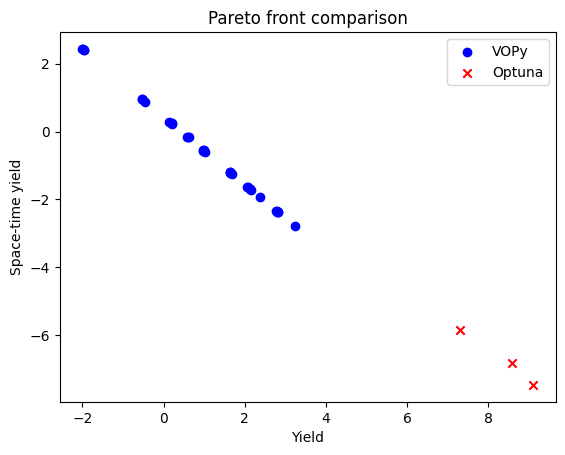

In [36]:
plt.scatter(vopy_p_f_W[:, 0], vopy_p_f_W[:, 1], label="VOPy", color="blue", marker="o")
plt.scatter(optuna_p_f_W[:, 0], optuna_p_f_W[:, 1], label="Optuna", color="red", marker="x")
plt.xlabel("Yield")
plt.ylabel("Space-time yield")
plt.title("Pareto front comparison")
plt.legend()
plt.show()